# LoopyPlot Tutorial

This tutorial shows the implemented features of LoopyPlot. We will answer the following questions:
* How to [configure function arguments](#Argument-Configuration)?
* How to [run loops](#Run-the-task-loops)?
* How to [plot the results](#Plot-Configuration)?
* How to [save and reload](#Save-and-Reload) the results?
* How to [define dependencies](#Dependency-Connections) between functions?

## Argument Configuration

The most interesting argument configuration are loops. Currently, LoopyPlot implements two types of loops: 
* a linear sweep and 
* a sequence of arbitrary values.

In this section we show how these loops can be arranged.

First of all we need to define the function of our experiment. In our case we just want to sum up two values in a noisy environment

In [1]:
import random


def sum_func(a, b, sigma=0):
    y = a + b
    y = y + random.gauss(0, sigma)
    return y

Afterwards we convert your `sum_func` function into a task object which parses the functions arguments and return values:

In [2]:
import loopyplot


tsum = loopyplot.Task(sum_func)

All the function arguments are imported as individual objects into the namespace of `tsum.args` which are used for configuration. (Hint: the tab-completion is very useful.)

In [3]:
tsum.args.sigma

<sum_func.args.sigma>

In the same way all the return values are collected in the namespace of `tsum.returns`. Since every argument and return value must have an unique name all these parameter objects are additionally collected in the namespace of `tsum.params`. In this ways we can access the function parameters by strings without knowing if it's an argument or a return value.

In [4]:
tsum.params['y']

<sum_func.returns.y>

### Nested Loops

Now we should configure the arguments of the `tsum` task. Basically an argument can be configured in three different ways:

* With a constant value: `argument.value = 1.2`

* With a linear sweep: `argument.sweep(1, 5, step=0.2)`

* With a sequence of values: `argument.iterate(5, 1, 2)`

First we add a little bit of noise

In [6]:
tsum.args.sigma.value = 0.1

And then we define a double loop over the arguments `a` and `b`

In [7]:
tsum.args.a.sweep(0, 1, num=3)
tsum.args.b.iterate(0, 100)

By default the loops are nested. This means that the inner loop is the sweep of argument `a` and the outer loop iterates over the given values of argument `b`.

The current argument configuration can be seen with

In [8]:
tsum.args

    a = 0.0	(1/3):	Sweep(0, 1, step=0.5)
    b = 0	(1/2):	Iterate(0, 100)
sigma = 0.1

Finally we can run the nested loop configuration

In [9]:
tsum.run()

run <sum_func> from 1/6 ...
................ to 6/6


and see the results as a pandas table

In [10]:
tsum.returns.as_table()

,a,b,sigma,y
0,0.0,0,0.1,0.208585
1,0.5,0,0.1,0.545780
2,1.0,0,0.1,1.014775
3,0.0,100,0.1,99.982569
4,0.5,100,0.1,100.601368
5,1.0,100,0.1,101.032868


### Zip loops together

In case you want to iterate over `a` and `b` arguments together you just zip them:

In [11]:
tsum.args.zip('a', 'b')

In [12]:
tsum.reset()
tsum.run()

run <sum_func> from 1/2 ...
................ to 2/2


In [13]:
tsum.returns.as_table(hide_const=True)

,a,b,y
0,0.0,0,-0.229517
1,0.5,100,100.396416


Since the `b` argument has only two values the total iteration stops with argument `a = 0.5`.

### Concatente loops

Sometimes we want to sweep one argument with different step sizes or directions. Then we define the single sweeps step-by-step and concatenate them together.

In [14]:
tsum = loopyplot.Task(sum_func)

tsum.args.a.sweep(0, 1, step=0.2)
tsum.args.a.sweep(1, 0, step=0.5, concat=True)

tsum.args.b.value = 10
tsum.args.sigma.value = 0.2

tsum.args

    a = 0.0	(1/9):	[Sweep(0, 1, step=0.2), Sweep(1, 0, step=-0.5)]
    b = 10
sigma = 0.2

In [15]:
tsum.run()

run <sum_func> from 1/9 ...
................ to 9/9


In [16]:
tsum.returns.as_table(hide_const=True)

,a,y
0,0.0,9.889777
1,0.2,9.953181
2,0.4,10.443904
3,0.6,10.372691
4,0.8,10.953693
5,1.0,10.692189
6,1.0,11.091216
7,0.5,10.474891
8,0.0,9.577256


## Run the task loops

Until now we have seen that we can run the configured loops of a task with `tsum.run()`.

But it's also possible to run the loop levels step-by-step. In order to demonstrate this we use a double loop configuration.

In [17]:
tsum = loopyplot.Task(sum_func)

tsum.args.a.sweep(1, 4)
tsum.args.b.iterate(0, 10, 20)
tsum.args.sigma.value = 0.1

One step of the inner loop is evaluated by

In [18]:
tsum.run(0)

run <sum_func>    1/12
    looping args:
        1/3: b = 0
        1/4: a = 1
    constant args:
        sigma = 0.1
    return values:
        y = 0.8323623


In [19]:
tsum.run(0)

run <sum_func>    2/12
    looping args:
        1/3: b = 0
        2/4: a = 2
    constant args:
        sigma = 0.1
    return values:
        y = 2.050439


The argument of the first loop level is `a`.

The argument of the second loop level is `b`. With `tsum.run(1)` we loop until all inner loops (in this case sweep of argument `a`) are finished. By this way we can move 'fast-forward' through the nested loops.

In [20]:
tsum.run(1)

run <sum_func> from  3/12 ...
    looping args:
        1/3: b = 0
        ...: a
    constant args:
        sigma = 0.1
................ to  4/12


In [21]:
tsum.returns.as_table()

,a,b,sigma,y
0,1,0,0.1,0.832362
1,2,0,0.1,2.050439
2,3,0,0.1,2.881653
3,4,0,0.1,4.077221


In [22]:
tsum.run(1)

run <sum_func> from  5/12 ...
    looping args:
        2/3: b = 10
        ...: a
    constant args:
        sigma = 0.1
................ to  8/12


In [23]:
tsum.returns.as_table()

,a,b,sigma,y
0,1,0,0.1,0.832362
1,2,0,0.1,2.050439
2,3,0,0.1,2.881653
3,4,0,0.1,4.077221
4,1,10,0.1,11.134786
5,2,10,0.1,12.023632
6,3,10,0.1,12.861344
7,4,10,0.1,13.809274


And finally we finish all loops simply with

In [24]:
tsum.run()

run <sum_func> from  9/12 ...
................ to 12/12


## Plot Configuration

This section shows two plotting scenarios. We will start with a simple parametric plot. Afterwards we show a more advanced plot configuration where we can explore the internal data relations interactively.

### Basic Plotting

In order to demonstrate the plotting features we create a cubic polynomial and play around with the arguments

In [25]:
def poly_func(x, a3=0, a2=0, a1=0, a0=0):
    y = a3*x**3 + a2*x**2 + a1*x + a0
    return y

In [26]:
poly = loopyplot.Task(poly_func)

poly.args.x.sweep(-2, 2, num=25)
poly.args.a0.iterate(5, -5)
poly.args.a1.iterate(-2, -5)
poly.args.zip('a0', 'a1')

poly.args.a2.iterate(2)
poly.args.a3.iterate(-2, 3)

Here we want just plot y(x) lines.

In [27]:
poly.plot('x', 'y')

Now you can decide how the plot figures are show. Either in an extra window or inside this notebook. For documentation purposes like this tutorial you should use the inline plots with

In [4]:
%matplotlib notebook

But for real development this is inconvenient due to the scrolling. Therefor it's better to place the browser window with the jupyter notebook side-by-side with the plotting window by removing the `notebook` argument. 

Note: If you want to change this behavior you have to restart the kernel.

In [29]:
#  %matplotlib

And now we can watch a live updating plot.

<IPython.core.display.Javascript object>


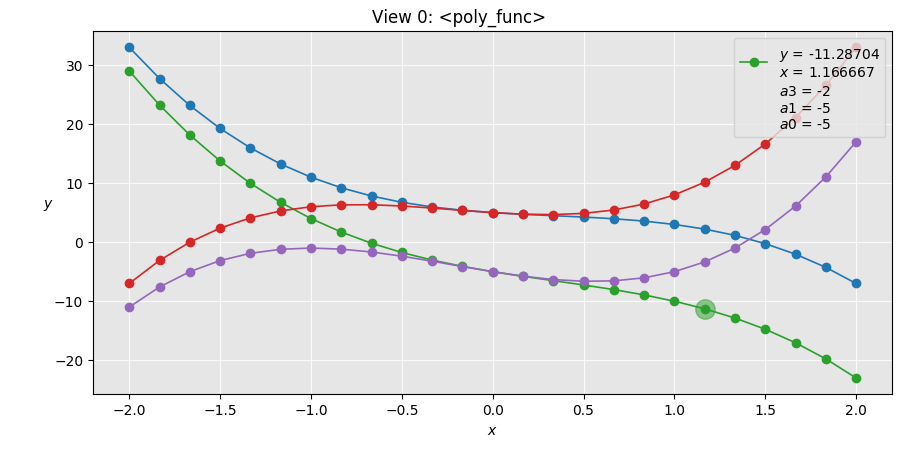

run <poly_func> from   1/100 ...
................. to 100/100


In [30]:
poly.run(plot_update=True)

You can click at any data point and the the coordinates together with the looped arguments are shown in the legend.

### Advanced Plotting: Data Cursor

In order to show the features of the data cursor we reuse the lissajous example from the README page and extend the plot configuration.

In [43]:
from numpy import pi, sin, cos


def lissajous(t, freq=2, phi=0):
    xpos = sin(2*pi * t)
    ypos = cos(2*pi*freq * t + phi)
    return xpos, ypos

lissajous = loopyplot.Task(lissajous)

lissajous.args.t.sweep(0, 2, num=50)
lissajous.args.phi.iterate(0, pi/4, pi/2, 3*pi/4)
lissajous.args.freq.iterate(0.5, 1, 2, 3)

In this experiment we iterate the argument `phi` and `freq` over four different values. So we would end up in 16 different lissajous curves. In order to make every argument permutation clickable we create two 'dummy' plots of the 
sweeped arguments and place them in the lower right corner of the plotting window.

In [44]:
lissajous.plot(y='phi', squeeze='phi', accumulate=[], row=2, col=1)
lissajous.plot(y='freq', squeeze='freq', accumulate=[], row=3, col=1)

The arguments of the first plot configuration have the following effects:

`y=phi`
* Plot all the values of the phi-argument on the y-axis.
* Since no x-parameter is given the phi-values are plotted over whose indices.

`squeeze='phi'`
* Every y-value with the same arguments EXCEPT the phi argument is *squeezed* on the same line

`accumulate=[]`
* When selecting a data point in an other axes show only the line from the selected arguments.
* Otherwise we would see many overlaid lines.

`row=2, col=1`
* Choose coordinates of the configured subplot.
* By default these values are zero.

The same is done with the `freq` argument.

In [45]:
lissajous.plot(x='xpos', y='ypos', squeeze='t', accumulate=[], row=(0, 1), col=0)

With this configuration we plot the current ypos(xpos) trajectory line and place this subplot over the first two rows.

In [46]:
lissajous.plot('t', 'ypos', accumulate=[], row=(0, 1), col=1)
lissajous.plot('xpos', 't', squeeze='t', accumulate=[], row=(2, 3), col=0)

With these two plot configurations we place the ypos- and xpos-trace beside the trajectory plot.

Now we can run the task and would see the plots.

run <lissajous> from   1/800 ...
................. to 800/800


<IPython.core.display.Javascript object>


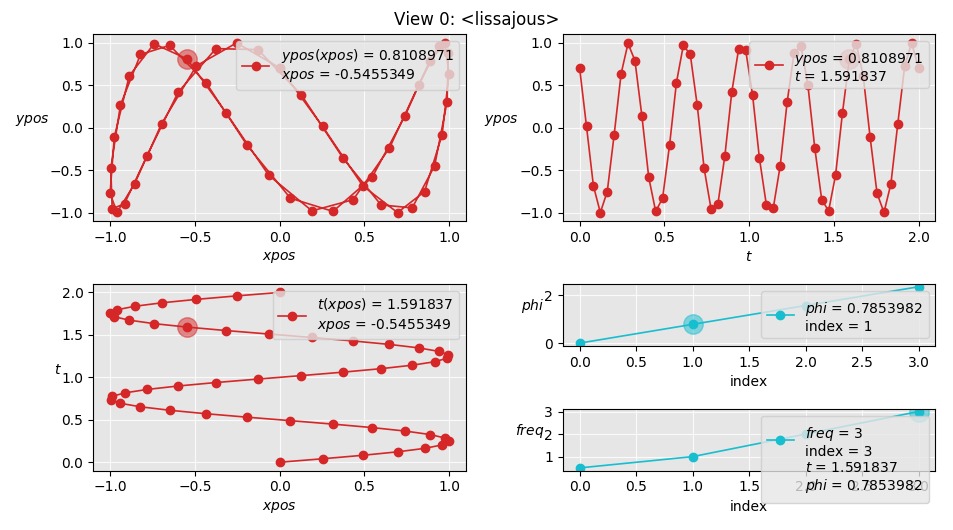

In [47]:
lissajous.run()

In order to choose one type of lissajous curve click into one of the two argument subplots in the lower right corner. Afterwards you can follow the time traces with the cursor.

If you want to resize the plot window then you can adjust the spacing with the following command.

In [48]:
lissajous.pm.draw()

## Save and Reload

Now we can save the results and plot configuration from the last lissajous experiment.

In [49]:
lissajous.to_csv()

save <lissajous> to lissajous.csv


Now a file `lissajous.csv` is created. In the beginning of the csv file the complete configuration of the lissajous task is saved in json structure as comments.

The first json part contains the argument configuration:

    ## {"__class__": "Task",
    ##  "name": "lissajous",
    ##  "func": "<some code in file...>",
    ##  "defaults": {"t": null,
    ##               "freq": 2,
    ##               "phi": 0},
    ##  "config": [{"cmd": "args.t.sweep",
    ##              "args": [0, 2],
    ##              "kwargs": {"num": 50}},
    ##             {"cmd": "args.phi.iterate",
    ##              "args": [0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345]},
    ##             {"cmd": "args.freq.iterate",
    ##              "args": [0.5, 1, 2, 3]},

In the second json part all the five plot configurations are saved:
    
    ##             {"cmd": "plot",
    ##              "kwargs": {"y": "phi",
    ##                         "squeeze": "phi",
    ##                         "accumulate": [],
    ##                         "row": 2,
    ##                         "col": 1}},
    ...
    ##             {"cmd": "plot",
    ##              "args": ["xpos", "t"],
    ##              "kwargs": {"squeeze": "t",
    ##                         "accumulate": [],
    ##                         "row": [2, 3],
    ##                         "col": 0}}]}

Afterwards the values of the arguments, return values and argument loop states are save in common structure of a csv file starting with a header:

    arg_t; arg_freq; arg_phi; xpos; ypos; state_t; state_freq; state_phi
    0.0; 0.5; 0; 0.0; 1.0; (0, 0); (0, 0); (0, 0)
    0.04081632653061224; 0.5; 0; 0.25365458390950735; 0.9917900138232462; (0, 1); (0, 0); (0, 0)
    0.08163265306122448; 0.5; 0; 0.49071755200393785; 0.9672948630390295; (0, 2); (0, 0); (0, 0)
    ...
    
These csv file can be reloaded in order to recreate the interactive plots.

<IPython.core.display.Javascript object>


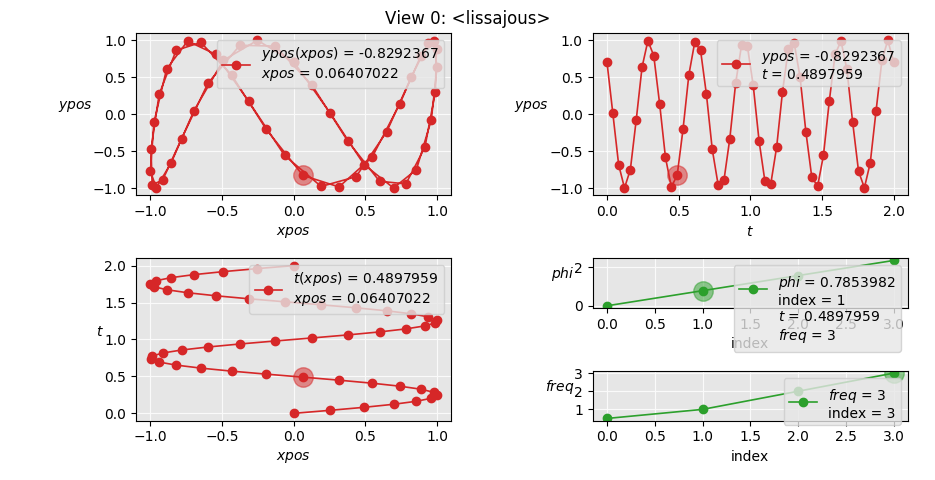

In [50]:
lissajous_from_csv = loopyplot.Task.read_csv('lissajous.csv')

## Dependency Connections

So far, we have seen how to configure, run and plot the results of a task derived from a plain python function.

Now we want to make an experiment which is divided into three parts. Assume we want to measure the transfer characteristic of a spring, which means to measure force over displacement. Afterwards we want to fit the measurements with a linear function and plot.

First of all we model our experiment data with a pure linear function and adding some noise to it. In this example we assume that we somehow can adjust the spring stiffness and offset.

In [5]:
%matplotlib notebook

import random


def spring(displacement: 'mm', stiffness: 'N/mm' = 1, offs: 'N' = 0):
    force: 'N' = stiffness * displacement + offs + random.gauss(0, 0.4)
    return force

Here we use the new variable annotation feature from python 3.6 in order to define the units of the function parameters which are used for the plot labels.

Now, we can configure the spring task. Since we plan to have several tasks which belong to the same experiment we add them to the *TaskManager*.

In [6]:
import loopyplot

spring = loopyplot.Task(spring)
spring.args.displacement.sweep(0, 2, num=5)
spring.args.stiffness.iterate(2, 1, 0.5)
spring.args.offs.iterate(0, 4, 7)
spring.args.zip('stiffness', 'offs')

spring.run()

run <spring> from  1/15 ...
.............. to 15/15


We zipped the two stiffness and offset loops in order to have only three parameter tuples instead of nine tuples (of the nested loop configuration) which would be the standard case. 

In order to see what's going on we can just plot the results.

<IPython.core.display.Javascript object>


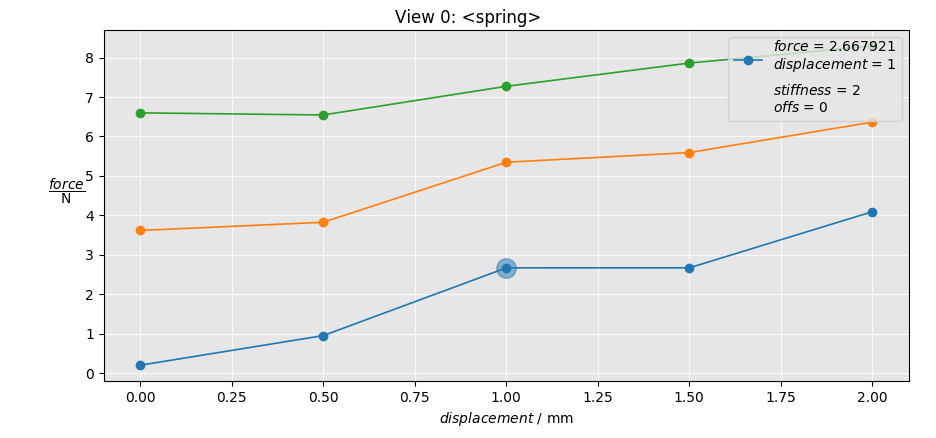

In [14]:
spring.plot('displacement', 'force')

Then we define a simple linear fitting function.

In [7]:
from numpy import polyfit


def fit(x, y):
    stiffness, offs = polyfit(x, y, 1)
    return stiffness, offs

fit = loopyplot.Task(fit)

fit.add_dependency(spring, squeeze='displacement')
fit.args.x.depends_on(spring.args.displacement)
fit.args.y.depends_on(spring.returns.force)

fit.run()

run <fit> from 1/3 ...
........... to 3/3


With that configuration we connect the results of the spring task to the fitting.

In line 9 we say that the spring task is a dependency of the fit task whereas the loop over `spring.args.displacement` is *squeezed* into one numpy array. Afterwards we connect the x, y arguments of the fit task to the parameters of the spring task.

We can validate the data relation by means of the the value tables.

In [16]:
spring.returns.as_table().head(3)

,displacement / mm,stiffness / N/mm,offs / N,force / N
0,0.0,2.0,0,0.199292
1,0.5,2.0,0,0.950059
2,1.0,2.0,0,2.667921


In [17]:
fit.args.as_table().head(1)

,x,y,spring|stiffness / N/mm,spring|offs / N
0,"[0.0, 0.5, 1.0, 1.5, 2.0]","[0.19929229741198062, 0.9500590493671527, 2.66...",2.0,0


All the first three lines of the spring results are *squeezed* into one array which is identified by the spring arguments `stiffness = 2` and `offs = 0`. The x argument of fit holds all the different displacement values of the spring task, and the y argument holds all the force values of spring. You can verify this relation for the other two result lines of the fit task.

And finally we want to apply the fitted model parameters (stiffness and offs) to the measurements. Therefore we just write down our linear model and connected it the the parameters of the fit-task. 

In [18]:
def model(xmeas, gain, offs):
    y_model = gain * xmeas + offs
    return y_model

model = loopyplot.Task(model)

model.add_dependency(fit)
model.args.xmeas.depends_on(fit.args.x)
model.args.gain.depends_on(fit.returns.stiffness)
model.args.offs.depends_on(fit.returns.offs)

Before we run the model task we can see the dependency relations as a graph. 

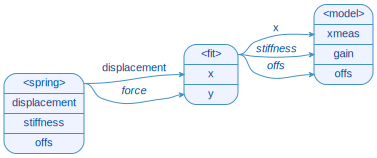

In [23]:
model.draw()

The nodes of the graph are the depending tasks showing the task name in the first row and the task arguments in the following rows.
The edges of the dependency graph are read as follows.
The displacement parameter (= argument) from `spring` is needed by (or injected into) the x argument from `fit`. The force parameter (= return value because it's italic) of `spring` is needed by y argument from `fit`. When you hover over the edge label you see the squeezed argument of this dependency.

And now we can run the `model` and explore the data relations between the raw measurements of the spring task and the fitted model by plotting the datas.

run <model> from 1/3 ...
............. to 3/3


<IPython.core.display.Javascript object>


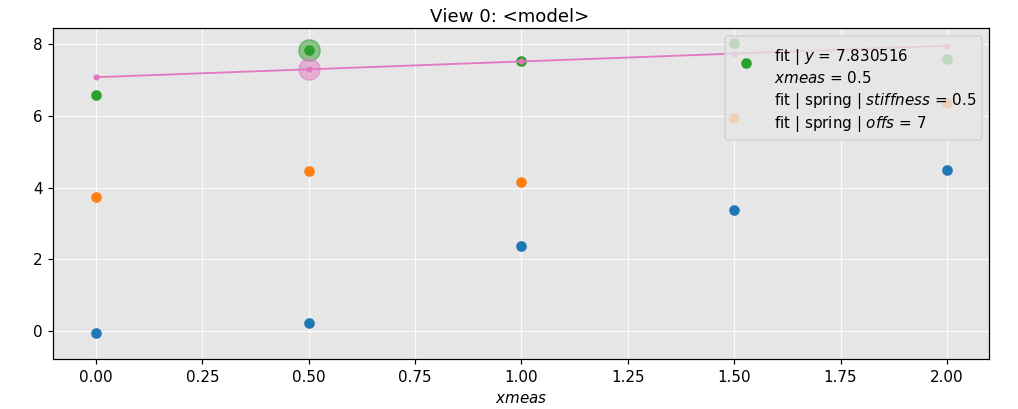

In [19]:
model.run()

model.plot('xmeas', fit.args.y, squeeze=[], linestyle='')
model.plot('xmeas', 'y_model', squeeze=[], accumulate=[], marker='.')

You can click on the different measurement points in order to see the linear fitting.